<a href="https://colab.research.google.com/github/callezenwaka/machine-learning/blob/main/Utilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilities for machine learning

# Set up

In [48]:
# import dependencies
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

In [49]:
# define seed
SEED = 1234

In [50]:
# define set seed function
def set_seeds(seed=1234):
  """Set seeds for reproducibility."""
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) # multi-GPU

In [51]:
# set seed for reproducibility
set_seeds(seed=SEED)

In [52]:
# set device
cuda = True
device = torch.device('cuda' if (torch.cuda.is_available() and cuda) else 'cpu')
torch.set_default_tensor_type('torch.FloatTensor')
if device.type == 'cuda':
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
print(device)

cuda


# Load Data

In [53]:
# import dependencies
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
# load data
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/spiral.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()


,X1,X2,color
0,0.106737,0.114197,c1
1,0.311513,-0.664028,c1
2,0.019870,-0.703126,c1
3,-0.054017,0.508159,c3
4,-0.127751,-0.011382,c3


In [55]:
# data shapes
X= df[['X1', 'X2']].values
y = df['color'].values
print("X: ", np.shape(X))
print("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


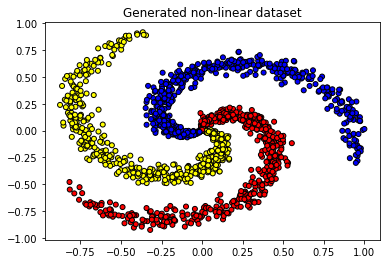

In [56]:
# visualize data
plt.title("Generated non-linear dataset")
colors = {'c1': 'red', 'c2': 'yellow', 'c3': 'blue'}
plt.scatter(X[: , 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors='k', s=25)
plt.show()

# Split Data

In [57]:
# import dependencies
import collections
from sklearn.model_selection import train_test_split

In [58]:
# set split size
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [59]:
# define train_val__test_split function
def train_val_test_split(X, y, train_size):
  """Split dataset into data splits."""
  X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [60]:
# create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X=X, y=y, train_size=TRAIN_SIZE)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"sample point: {X_train[0]} → {y_train[0]}")

X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
sample point: [-0.63919105 -0.69724176] → c1


# Label Encoding

In [61]:
# import dependencies
import itertools

In [62]:
# declare LabelEncoder class
class LabelEncoder(object):
  """Label encoder for tag labels."""

  def __init__(self, class_to_index={}):
    """Initialize Label Encoder class."""
    self.class_to_index = class_to_index
    self.index_to_class = {v: k for k, v in self.class_to_index.items()}
    self.classes = list(self.class_to_index.keys())

  def __len__(self):
    return len(self.class_to_index)

  def __str__(self):
    return f"<LabelEncoder(num_classes={len(self)})>"

  def fit(self, y):
    classes = np.unique(y)
    for i, class_ in enumerate(classes):
      self.class_to_index[class_] = i
    self.index_to_class = {v: k for k, v in self.class_to_index.items()}
    self.classes = list(self.class_to_index.keys())
    return self

  def encode(self, y):
    encoded = np.zeros((len(y)), dtype=int)
    for i, item in enumerate(y):
      encoded[i] = self.class_to_index[item]
    return encoded

  def decode(self, y):
    classes = []
    for i, item in enumerate(y):
      classes.append(self.index_to_class[item])
    return classes

  def save(self, fp):
    with open(fp, 'w') as fp:
      contents = {'class_to_index': self.class_to_index}
      json.dump(contents, fp, indent=4, sort_keys=False)

  @classmethod
  def load(cls, fp):
    with open(fp, 'r') as fp:
      kwargs = json.load(fp=fp)
    return cls(**kwargs)

In [63]:
# encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{'c1': 0, 'c2': 1, 'c3': 2}

In [64]:
# convert labels to tokens
print(f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print(f"y_train[0]: {y_train[0]}")

y_train[0]: c1
y_train[0]: 0


In [65]:
# class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print(f"counts: {counts}\nweights: {class_weights}")

counts: [350 350 350]
weights: {0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


# Standardize Data

In [66]:
# declare StandardScaler class
class StandardScaler(object):
  """Declare StandardScaler class."""
  
  def __init__(self, mean=None, std=None):
    """Initialize StandardScaler class."""
    self.mean = np.array(mean)
    self.std = np.array(std)

  def fit(self, X):
    self.mean = np.mean(X_train, axis=0)
    self.std = np.std(X_train, axis=0)

  def scale(self, X):
    return (X - self.mean) / self.std
  
  def unscale(self, X):
    return (X * self.std) + self.mean

  def save(self, fp):
    with open(fp, 'w') as fp:
      contents = {'mean': self.mean.tolist(), 'std': self.std.tolist()}
      json.dump(contents, fp, indent=4, sort_keys=False)

  @classmethod
  def load(cls, fp):
    with open(fp, 'r') as fp:
      kwargs = json.load(fp=fp)
    return cls(**kwargs)

In [67]:
# standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler()
X_scaler.fit(X_train)
print(X_scaler)

In [68]:
# apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.scale(X_train)
X_val = X_scaler.scale(X_val)
X_test = X_scaler.scale(X_test)

In [69]:
# chck:(means should be ~0 and std should be ~1)
print(f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print(f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: 0.1, std: 0.9
X_test[1]: mean: 0.0, std: 1.0


# Dataloader

In [70]:
# import dependencies
import torch

In [71]:
# set seed for reproducibility
torch.manual_seed(SEED)

In [72]:
# declare Dataset class
class Dataset(torch.utils.data.Dataset):
  """Declare Dataset class."""

  def __init__(self, X, y):
    """Initialize Dataset class."""
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __str__(self):
    return f"<Dataset(N={len(self)})>"

  def __getitem__(self, index):
    X = self.X[index]
    y = self.y[index]
    return X, y

  def collate_fn(self, batch):
    """Processing on a batch."""
    # get inputs
    batch = np.array(batch, dtype=object)
    X = np.stack(batch[:, 0], axis=0)
    y = np.stack(batch[:, 1], axis=0)

    # cast
    X = torch.FloatTensor(X.astype(np.float32))
    y = torch.LongTensor(y.astype(np.int32))

    return X, y

  def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
    return torch.utils.data.DataLoader(dataset=self, 
                                       batch_size=batch_size, 
                                       collate_fn=self.collate_fn, 
                                       shuffle=shuffle, 
                                       drop_last=drop_last, 
                                       pin_memory=True)

In [73]:
# create datasets
train_dataset = Dataset(X=X_train, y=y_train)
val_dataset = Dataset(X=X_val, y=y_val)
test_dataset = Dataset(X=X_test, y=y_test)
print("Dataset:\n"
      f"Train dataset: {train_dataset.__str__()}\n"
      f"Val dataset: {val_dataset.__str__()}\n"
      f"Test dataset: {test_dataset.__str__()}\n"
      "Sample point:\n"
      f"X: {train_dataset[0][0]}\n"
      f"y: {train_dataset[0][1]}")

Dataset:
Train dataset: <Dataset(N=1050)>
Val dataset: <Dataset(N=225)>
Test dataset: <Dataset(N=225)>
Sample point:
X: [-1.47355106 -1.67417243]
y: 0


In [74]:
# create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print("Sample batch: \n"
      f"X: {list(batch_X.size())}\n"
      f"y: {list(batch_y.size())}\n"
      "Sample point:\n"
      f"X: {batch_X[0]}\n"
      f"y: {batch_y[0]}")

Sample batch: 
X: [64, 2]
y: [64]
Sample point:
X: tensor([-1.4736, -1.6742], device='cpu')
y: 0


#Device

In [75]:
# set CUDA seeds
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # multi-GPU

In [76]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


# Model

In [77]:
# import dependencies
import math
from torch import nn
import torch.nn.functional as F

In [78]:
# intialize hyperparameters
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
HIDDEN_DIM = 100
DROPOUT_P = 0.1
NUM_CLASSES = len(label_encoder.classes)
NUM_EPOCHS = 10

In [79]:
# declare MLP class
class MLP(nn.Module):
  """Declare MLP class."""

  def __init__(self, input_dim, hidden_dim, dropout_p, num_classes):
    """Initialize MLP class."""
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.dropout = nn.Dropout(dropout_p)
    self.fc2 = nn.Linear(hidden_dim, num_classes)

  def forward(self, inputs):
    x_in, = inputs
    z = F.relu(self.fc1(x_in))
    z = self.dropout(z)
    z = self.fc2(z)
    return z

In [80]:
# initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES, dropout_p=DROPOUT_P)
model = model.to(device) # set device
print("model:\n", model.named_parameters)

model:
 <bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


# Training

In [81]:
# import dependencies
from torch.optim import  Adam

In [82]:
# initialize hyperparameters
LEARNING_RATE = 1e-2
NUM_EPOCHS = 100
PATIENCE = 3

In [83]:
# define loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [84]:
# define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [91]:
# declare trainer class
class Trainer(object):
  """Declare Trainer class."""

  def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):
    """Initialize Trainer class."""

    # set params
    self.model = model
    self.device = device
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.scheduler = scheduler

  def train_step(self, dataloader):
    """Train step."""

    # set model to train mode
    self.model.train()
    loss = 0.0

    # iterate over train batches
    for i, batch in enumerate(dataloader):
      # step
      # set device
      batch = [item.to(self.device) for item in batch]
      inputs, targets = batch[:-1], batch[-1]

      # reset gradients
      self.optimizer.zero_grad()

      # forward pass
      z = self.model(inputs)

      # define loss
      J = self.loss_fn(z, targets)

      # backward pass
      J.backward()

      # update weights
      self.optimizer.step()

      # cumulative metrics
      loss += (J.detach().item() - loss) / (i + 1)

    return loss

  def eval_step(self, dataloader):
    """Validation or test step."""

    # set model to eval mode
    self.model.eval()
    loss = 0.0
    y_trues, y_probs = [], []

    # iterate over val batches
    with torch.inference_mode():
      for i, batch in enumerate(dataloader):
        #step
        # set device
        batch = [item.to(device) for item in batch]
        inputs, y_true = batch[:-1], batch[-1]

        # forward pass
        z = self.model(inputs)
        J = self.loss_fn(z, y_true).item()

        # cumulative metrics
        loss += (J - loss) / (i + 1)

        # store outputs
        y_prob = F.softmax(z).cpu().numpy()
        y_probs.extend(y_prob)
        y_trues.extend(y_true.cpu().numpy())

    return loss, np.vstack(y_trues), np.vstack(y_probs)

  def predict_step(self, dataloader):
    """Prediction step"""
    
    # set model to eval mode
    self.model.eval()
    y_probs = []

    # iterate over val batches
    with torch.inference_mode():
      for i, batch in enumerate(dataloader):

        # forward pass w/ inputs
        inputs, targets = batch[:-1], batch[-1]
        z = self.model(inputs)

        # store outputs
        y_prob = F.softmax(z).cpu().numpy()
        y_probs.extend(y_prob)
    
    return np.vstack(y_probs)

  def train(self, num_epochs, patience, train_dataloader, val_dataloader):
    best_val_loss = np.inf
    for epoch in range(num_epochs):
      # step
      train_loss = self.train_step(dataloader=train_dataloader)
      val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
      self.scheduler.step(val_loss)

      # earlt stopping
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = self.model
        _patience = patience # reset _patience
      else:
        _patience -= 1
      if not _patience: # 0
        print("Stopping early!")
        break
      
      # logging
      print(
          f"Epoch: {epoch+1} |"
          f"train_loss: {train_loss:.5f},"
          f"val_loss: {val_loss:.5f},"
          f"lr: {self.optimizer.param_groups[0]['lr']:.2E},"
          f"_patience: {_patience}"
      )
    return best_model

In [92]:
# trainer module
trainer = Trainer(model=model, device=device, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

In [94]:
# train
best_model = trainer.train(NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 |train_loss: 0.04336,val_loss: 0.01462,lr: 1.00E-03,_patience: 3
Epoch: 2 |train_loss: 0.03451,val_loss: 0.01448,lr: 1.00E-03,_patience: 3
Epoch: 3 |train_loss: 0.03109,val_loss: 0.01439,lr: 1.00E-03,_patience: 3
Epoch: 4 |train_loss: 0.03125,val_loss: 0.01434,lr: 1.00E-03,_patience: 3
Epoch: 5 |train_loss: 0.03048,val_loss: 0.01441,lr: 1.00E-03,_patience: 2
Epoch: 6 |train_loss: 0.02837,val_loss: 0.01443,lr: 1.00E-03,_patience: 1
Stopping early!


# Evaluation

In [95]:
# import dependencies
import json
from sklearn.metrics import precision_recall_fscore_support

In [96]:
# define get metrics function
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [97]:
# get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [98]:
# determine performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print(json.dumps(performance['overall'], indent=2))

{
  "precision": 0.9956140350877192,
  "recall": 0.9955555555555555,
  "f1": 0.9955553580159118,
  "num_samples": 225.0
}


# Saving & Loading Model

In [99]:
# import dependencies
from pathlib import Path

In [100]:
# save artifacts
dir = Path("mlp")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, 'label_encoder.json'))
X_scaler.save(fp=Path(dir, 'X_scaler.json'))
torch.save(best_model.state_dict(), Path(dir, 'model.pt'))
with open(Path(dir, 'performance.json'), "w") as fp:
  json.dump(performance, indent=2, sort_keys=False, fp=fp)

In [103]:
# load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, 'label_encoder.json'))
X_scaler = StandardScaler.load(fp=Path(dir, 'X_scaler.json'))
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(Path(dir, 'model.pt'), map_location=device))
model.to(device)

MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)

In [104]:
# initialize trainer
trainer = Trainer(model=model, device=device)

In [105]:
# dataloader
sample = [[0.106737, 0.114197]] # c1
X = X_scaler.scale(sample)
y_filter = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filter)
dataloader = dataset.create_dataloader(batch_size=batch_size)

In [106]:
# inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


['c1']